In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,balanced_accuracy_score, accuracy_score
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb # faster and lighter

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

import warnings
warnings.filterwarnings('ignore')

# Exploring the Dataset

In [2]:
data = pd.read_csv("data/starcraft_player_data.csv")
data.shape

(3395, 20)

In [3]:
# checking how much data is given
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [4]:
data.tail()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
3394,10095,8,?,?,?,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


### Missing Values in Age, HoursPerWeek, TotalHours
I noticed while printing the tail of the dataframe (and while getting the correlation matrix) that Age, HoursPerWeek, TotalHours do not have nan values, but have '?' for missing values.

In [5]:
# checking for nan values in the data
# no nan values present
data.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [6]:
data = data.replace('?', np.nan)

In [7]:
data.isna().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [8]:
data[data.isna().any(axis=1)]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17,20,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
1841,5255,5,18,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000


##### Note - The columns Age, HoursPerWeek, TotalHours have around similar missing values. Now, we can either drop it or try to impute them using the mean of nearest neighbors (KNNImputer). 
I do not want to drop it since the dataset only has 3395 rows and for the missing rows of Age, HoursPerWeek and Total hours, we have all the other data. I chose KNN imputation, where I will use selected variables to create a K Nearest Neighbor cluster and then use the cluster to impute the missing values

In [9]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data), columns = data.columns)
data_imputed['Age'] = pd.to_numeric(data_imputed['Age'].round())
data_imputed['HoursPerWeek'] = pd.to_numeric(data_imputed['HoursPerWeek'].round())

In [10]:
data_imputed.Age.value_counts()

21.0    394
20.0    362
18.0    325
22.0    314
19.0    313
23.0    259
16.0    256
17.0    248
24.0    225
25.0    168
26.0    136
27.0    111
28.0     73
29.0     52
30.0     32
31.0     29
32.0     21
35.0     17
33.0     15
34.0     15
36.0      8
38.0      5
37.0      5
40.0      4
41.0      3
39.0      3
43.0      1
44.0      1
Name: Age, dtype: int64

In [11]:
data_imputed.HoursPerWeek.value_counts()

10.0     411
8.0      390
20.0     348
12.0     331
6.0      323
28.0     280
24.0     233
16.0     223
4.0      219
14.0     182
2.0      108
42.0      92
30.0      54
36.0      50
19.0      37
56.0      33
18.0      26
40.0      12
70.0       9
48.0       7
32.0       5
50.0       5
21.0       3
96.0       2
84.0       2
60.0       2
0.0        1
72.0       1
90.0       1
98.0       1
140.0      1
80.0       1
168.0      1
112.0      1
Name: HoursPerWeek, dtype: int64

Rank Player_Count
1    167
2    347
3    553
4    811
5    806
6    621
7     35
8     55
Name: LeagueIndex, dtype: int64


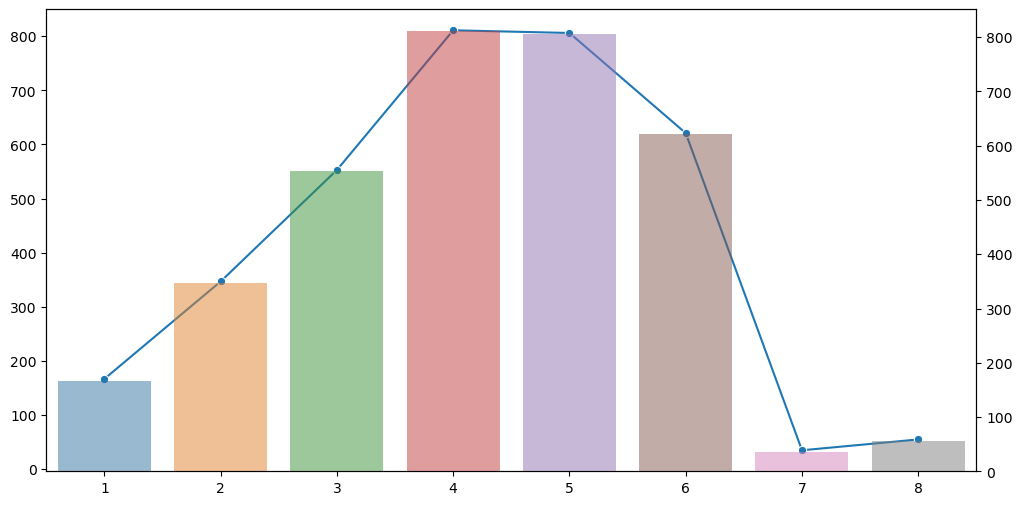

In [12]:
# Rank Distribution
rank_counts = data.LeagueIndex.value_counts().sort_index()
print("Rank Player_Count")
print(rank_counts)
fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data= rank_counts.values, marker='o', ax=ax1)
ax2 = ax1.twinx()
sns.barplot(x=rank_counts.index, y=rank_counts.values, alpha=0.5, ax=ax2)
plt.show()

In [13]:
data_imputed.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.635935,15.965243,957.998468,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.173323,11.871884,17172.106437,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


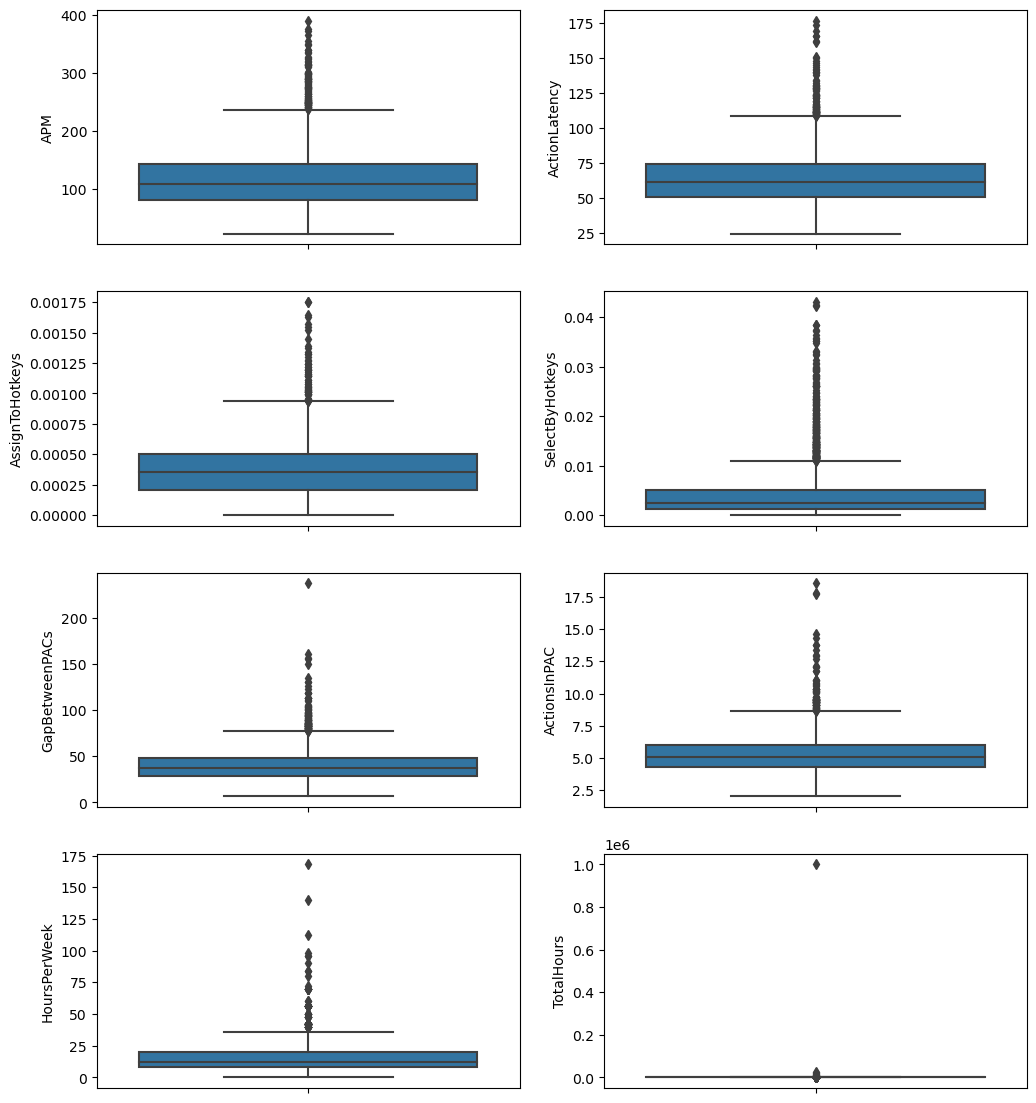

In [14]:
fig2, ax2_1 = plt.subplots(4, 2, figsize=(12,14))
sns.boxplot(y=data_imputed.APM, ax=ax2_1[0][0])
sns.boxplot(y=data_imputed.ActionLatency, ax=ax2_1[0][1])
sns.boxplot(y=data_imputed.AssignToHotkeys, ax=ax2_1[1][0])
sns.boxplot(y=data_imputed.SelectByHotkeys, ax=ax2_1[1][1])
sns.boxplot(y=data_imputed.GapBetweenPACs, ax=ax2_1[2][0])
sns.boxplot(y=data_imputed.ActionsInPAC, ax=ax2_1[2][1])
sns.boxplot(y=data_imputed.HoursPerWeek, ax=ax2_1[3][0])
sns.boxplot(y=data_imputed.TotalHours, ax=ax2_1[3][1])
plt.show()

We clearly see that there is an outlier in TotalHours which we have to remove as it is not possible for an 18 year old to have 1000000 hours of gameplay. I also saw the difference it made in the correlation between TotalHours and the target variable as it went from around 0.02 to 0.26 (I just thought this was interesting given just one row was affecting the whole column)

In [15]:
data_imputed[data_imputed.TotalHours == data_imputed.TotalHours.max()]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
1793,5140.0,5.0,18.0,24.0,1000000.0,281.4246,0.023428,0.000799,5.0,0.000041,0.000447,0.005136,28.1164,36.1266,5.8522,29.0,0.001328,6.0,0.0,0.0


In [16]:
data_imputed = data_imputed.drop(1793).reset_index(drop=True)

In [17]:
# option to convert all values of Professional = GrandMaster, since Professional is not a rank and we have less data
#data_imputed.loc[data_imputed['LeagueIndex']==8, 'LeagueIndex'] = 7.0

# New Rank Distribution
#new_rank_counts = data_imputed.LeagueIndex.value_counts().sort_index()
#print("New Rank Player_Count")
#print(new_rank_counts)
#fig, ax1 = plt.subplots(figsize=(12,6))
#sns.lineplot(data= new_rank_counts.values, marker='o', ax=ax1)
#ax2 = ax1.twinx()
#sns.barplot(x=new_rank_counts.index, y=new_rank_counts.values, alpha=0.5, ax=ax2)
#plt.show()

In [18]:
data_imputed.corr()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,1.000000,0.102586,0.080579,-0.015732,0.034291,0.159812,0.160982,0.136187,0.117358,0.074059,0.046578,0.089612,-0.102554,-0.087197,0.047242,0.032284,-0.011657,0.021214,-0.027080,0.003267
LeagueIndex,0.102586,1.000000,-0.128045,0.217715,0.263904,0.662814,0.490995,0.531128,0.351190,0.312618,0.233217,0.612208,-0.553198,-0.673945,0.143069,0.220567,0.295579,0.133560,0.148932,0.145830
Age,0.080579,-0.128045,1.000000,-0.184955,-0.033285,-0.201266,-0.124789,-0.104306,0.011697,0.036290,-0.022011,-0.195038,0.113943,0.239745,-0.046036,-0.024271,-0.091522,0.023266,-0.079150,-0.065581
HoursPerWeek,-0.015732,0.217715,-0.184955,1.000000,0.255747,0.240321,0.197472,0.158079,0.074512,0.087644,0.052008,0.176916,-0.137511,-0.191790,0.095903,0.064626,0.050641,0.037280,0.057907,0.074218
TotalHours,0.034291,0.263904,-0.033285,0.255747,1.000000,0.249000,0.205055,0.130998,0.088151,0.132819,0.088370,0.183148,-0.160895,-0.206847,0.080640,0.090374,0.100132,0.052434,0.042355,0.058752
APM,0.159812,0.662814,-0.201266,0.240321,0.249000,1.000000,0.840179,0.577809,0.361992,0.271752,0.322509,0.650898,-0.575502,-0.722349,0.384200,0.220240,0.349693,0.101263,0.136850,0.132287
SelectByHotkeys,0.160982,0.490995,-0.124789,0.197472,0.205055,0.840179,1.000000,0.503746,0.302396,0.197915,0.143477,0.397642,-0.304139,-0.414784,0.163187,0.082665,0.141394,0.006440,0.044661,0.061730
AssignToHotkeys,0.136187,0.531128,-0.104306,0.158079,0.130998,0.577809,0.503746,1.000000,0.420318,0.242523,0.193057,0.486249,-0.396733,-0.481791,0.093503,0.192538,0.182852,0.133061,0.144984,0.154796
UniqueHotkeys,0.117358,0.351190,0.011697,0.074512,0.088151,0.361992,0.302396,0.420318,1.000000,0.180625,0.141566,0.372105,-0.242779,-0.323091,-0.016431,0.264613,0.108102,0.225058,0.110411,0.102501
MinimapAttacks,0.074059,0.312618,0.036290,0.087644,0.132819,0.271752,0.197915,0.242523,0.180625,1.000000,0.242290,0.177593,-0.237728,-0.200115,0.134849,0.166510,0.077687,0.120798,0.040186,0.044476


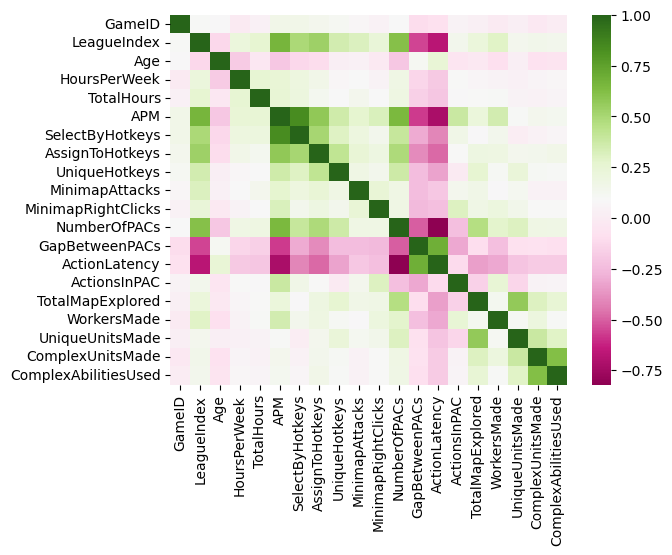

In [19]:
sns.heatmap(data_imputed.corr(), cmap="PiYG")
plt.show()

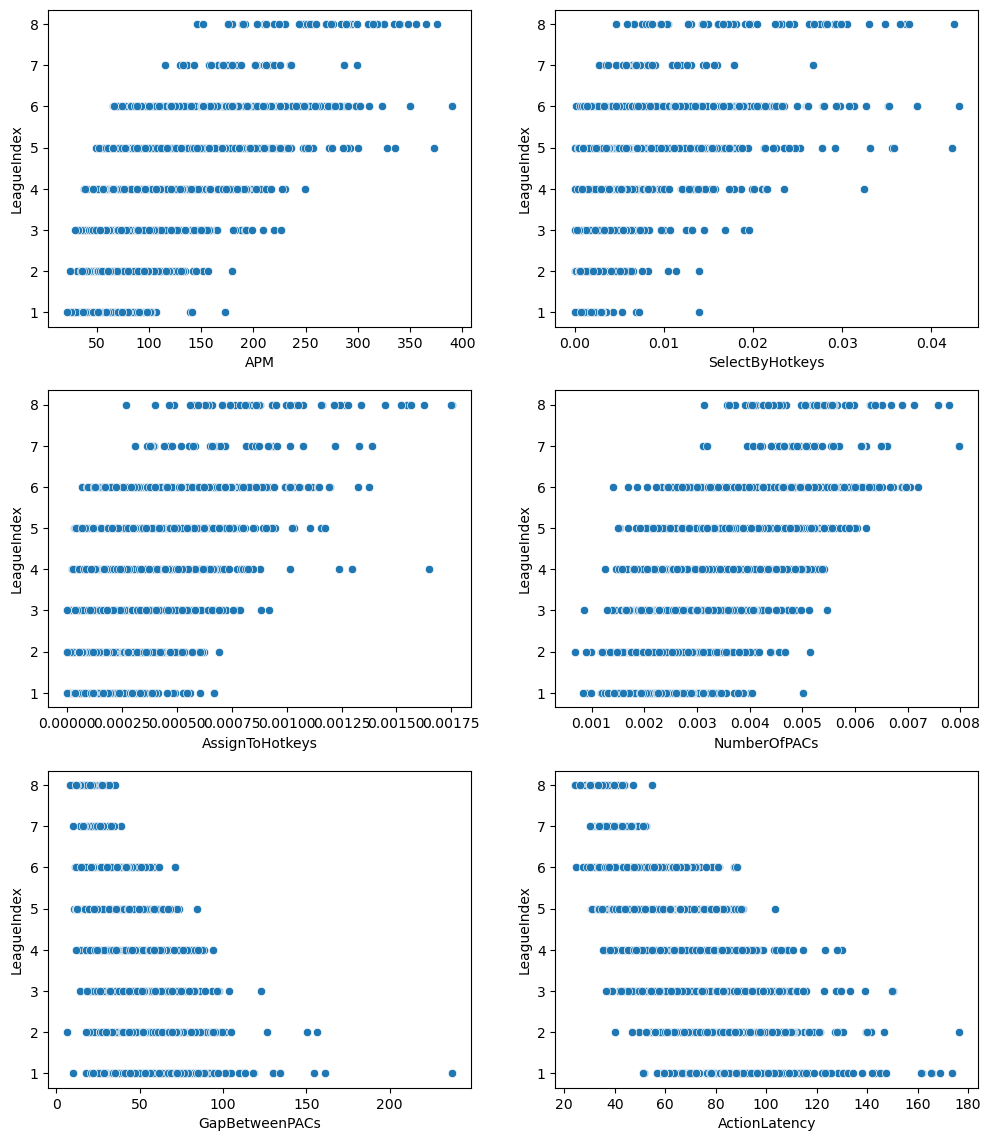

In [20]:
fig3, ax3_1 = plt.subplots(3, 2, figsize=(12,14))
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.APM, ax=ax3_1[0][0])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.SelectByHotkeys, ax=ax3_1[0][1])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.AssignToHotkeys, ax=ax3_1[1][0])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.NumberOfPACs, ax=ax3_1[1][1])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.GapBetweenPACs, ax=ax3_1[2][0])
sns.scatterplot(y = data_imputed.LeagueIndex, x=data_imputed.ActionLatency, ax=ax3_1[2][1])
plt.show()

#### Moderately to Highly Correlated Variables with Rank/LeagueIndex (considering values above 0.4 or below -0.6)
- APM - 0.66
- SelectByHotkeys - 0.49
- AssignToHotkeys - 0.53
- NumberOfPACs - 0.61
- GapBetweenPACs - -0.55
- ActionLatency - -0.67

#### Low Correlation with Rank/LeagueIndex
- UniqueHotkeys - 0.35
- MinimapAttacks - 0.31
- WorkersMade - 0.29
- TotalHours - 0.26

Plotting the variables with the ranks shows us that these independent variables do form a pattern that can help predict the ranks.

##### Note - We could use Pearson Correlation measure to select variables that best predict the target variable, however, the variables to be selected are also highly correlated with other selected variables which leads to multicollinearity. Therefore, I will not use Pearson Correlation for feature selection.  

# Dropping Variables

In [21]:
col_drop = ['GameID']
data_imputed = data_imputed.drop(columns=col_drop)

# Modeling

In [22]:
#Creating model class so that testing and tuning is easy to run all the different models.
class Model_Data:
    def __init__(self, model_ud, datafile, scoring='roc_auc_ovr', col="LeagueIndex"):
        self.df = datafile
        self.user_defined_model=model_ud
        self.col=col
        self.X= self.df.loc[:, ~self.df.columns.isin([self.col])]
        self.y = self.df[self.col]
        self.scoring = scoring
        
    def split(self, test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size, 
                                                                               stratify=self.y, random_state = 42)
            
    def tune(self, params):

        cv = StratifiedKFold(n_splits=3)
        self.rand_search = GridSearchCV(estimator=self.user_defined_model, param_grid=params, n_jobs=8, 
                                         cv=cv, scoring=self.scoring, verbose=2)

            
        self.rand_search = self.rand_search.fit(self.X_train, self.y_train)
        # summarize results
        print("Best: %f using %s" % (self.rand_search.best_score_, self.rand_search.best_params_))

        means = self.rand_search.cv_results_['mean_test_score']
        stds = self.rand_search.cv_results_['std_test_score']
        parameters = self.rand_search.cv_results_['params']
        for mean, stdev, parameters in zip(means, stds, parameters):
            print("%f (%f) with: %r" % (mean, stdev, parameters))
            
    def tune_comp(self, params):

        cv = StratifiedKFold(n_splits=2)
        self.rand_search = RandomizedSearchCV(estimator=self.user_defined_model, param_grid=params, n_jobs=8,
                                     cv=cv, scoring=self.scoring, verbose=2)
            
        self.rand_search = self.rand_search.fit(self.X, self.y)
        # summarize results
        print("Best: %f using %s" % (self.rand_search.best_score_, self.rand_search.best_params_))

        means = self.rand_search.cv_results_['mean_test_score']
        stds = self.rand_search.cv_results_['std_test_score']
        parameters = self.rand_search.cv_results_['params']
        for mean, stdev, parameters in zip(means, stds, parameters):
            print("%f (%f) with: %r" % (mean, stdev, parameters))
    
    def fit(self):
        self.user_defined_model.set_params(**self.rand_search.best_params_)
        self.user_defined_model = self.user_defined_model.fit(self.X_train, self.y_train)
        
    def fit_comp(self):
        self.user_defined_model.set_params(**self.rand_search.best_params_)
        self.user_defined_model = self.user_defined_model.fit(self.X, self.y)
    
    def predict(self, input_value=None):
        if input_value == None:
            result = self.user_defined_model.predict(self.X_test)
        else: 
            result = self.user_defined_model.predict(np.array([input_value]))
        return result

    def AccuracyReport(self, predictions, input_value=None):
        if input_value == None:
            print(confusion_matrix(self.y_test,predictions))
            print(classification_report(self.y_test,predictions))
            acc2 = balanced_accuracy_score(self.y_test,predictions)
            acc3 = accuracy_score(self.y_test,predictions)
            print("Balanced Accuracy Score --> ",acc2)
            print("Accuracy Score --> ", acc3)
        else:
            print(confusion_matrix(np.array([input_value]),predictions))
            print(classification_report(np.array([input_value]),predictions))
            acc2 = balanced_accuracy_score(np.array([input_value]),predictions)
            print("Balanced Accuracy Score --> ",acc2)

### Scaling Data

In [23]:
scaler = StandardScaler()
le = LabelEncoder()
data_imputed_vals = data_imputed.iloc[:,1:]
league_ranks = data_imputed.loc[:,'LeagueIndex']
league_ranks = le.fit_transform(league_ranks)
scaled_data = scaler.fit_transform(data_imputed_vals)
scaled_data = pd.DataFrame(scaled_data, columns=['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys',
       'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionLatency',
       'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'])
scaled_data['LeagueIndex'] = league_ranks
scaled_data

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,LeagueIndex
0,1.285209,-0.502303,2.751030,0.515138,-0.147485,-0.683910,1.116606,0.069483,0.012993,1.397997,-0.448772,-1.189633,-0.349222,0.790005,0.703303,-0.287552,-0.535174,-0.535072,4
1,0.326633,-0.502303,5.106005,0.235859,-0.187556,-0.507034,-0.154415,1.180051,0.119410,0.851587,-0.434098,-1.112781,-0.287274,-0.017446,0.311961,-0.825860,-0.535174,0.247515,4
2,2.004141,-0.502303,-0.545934,-0.906856,-0.605196,-0.168494,-0.154415,1.177444,0.196262,-0.541034,0.249665,0.603507,-0.822729,-0.017446,-0.553097,-0.287552,-0.535174,0.176597,3
3,-0.631943,0.340081,-0.310436,-0.181168,-0.618004,-0.713249,-1.425436,-0.271591,0.413768,0.322778,-0.649760,-0.520580,-0.239040,-0.421172,-1.166509,0.250756,-0.535174,0.911113,2
4,2.483430,-0.502303,-0.192688,0.113600,-0.598575,-0.205167,-1.001762,-0.592782,2.496395,-1.103055,-1.030572,-0.086634,2.743628,-0.959474,0.275351,-1.364167,-0.535174,-0.462480,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,-0.152655,0.255842,0.182931,2.749855,3.058710,1.643618,1.963953,3.152140,-0.639955,1.101753,-1.268593,-1.087366,0.670712,3.212361,-0.298002,-0.825860,-0.535174,-0.535072,7
3390,-0.152655,0.340081,0.234740,3.811006,4.503062,3.486110,2.387626,0.891580,1.845887,0.803537,-1.519499,-1.436692,1.286914,-0.824898,-0.469626,-1.364167,-0.535174,-0.535072,7
3391,-0.152655,0.255842,0.182931,3.517152,4.559541,2.165181,1.116606,1.444629,-0.579438,0.984930,-1.630242,-1.259913,0.752663,-0.421172,0.439325,-1.364167,-0.535174,-0.535072,7
3392,-0.392299,0.255842,0.144074,4.990842,6.094344,0.982208,0.269259,0.638790,1.041261,0.890403,-1.671741,-1.502251,1.798687,-0.959474,-0.806882,-0.287552,-0.535174,1.845489,7


### Logistic Regression

In [24]:
log_model = Model_Data(LogisticRegression(multi_class='multinomial'), scaled_data)
log_model.split(test_size=0.25)
param_grid = {
    'penalty' : ['l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','sag','saga'],
    'max_iter' : [100, 500, 1000, 2000]
}

In [25]:
%%time
log_model.tune(param_grid)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits
Best: 0.839631 using {'C': 0.615848211066026, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
0.798868 (0.006041) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.798854 (0.006054) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.798717 (0.006134) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
0.798680 (0.006181) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
nan (nan) with: {'C': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.798868 (0.006041) with: {'C': 0.0001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7988

In [26]:
log_model.fit()

In [27]:
coef_table = pd.DataFrame(log_model.user_defined_model.coef_, columns = [list(log_model.X.columns)])
coef_table

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,-0.085052,0.093315,-1.892705,-0.816181,-0.576271,-0.796550,-0.181093,-1.020055,-0.162302,-0.551077,0.718901,1.139276,0.144015,0.151156,-0.599217,0.270225,-0.123436,-0.009091
1,-0.143408,0.093160,-1.274280,-0.818109,-0.060375,-0.563769,-0.214090,-0.313022,-0.041473,-0.711746,0.634345,0.709804,0.261726,0.232800,-0.222437,0.197765,-0.226292,0.151763
2,-0.091674,-0.023668,-0.037680,0.416307,-0.676073,-0.291111,-0.127837,-0.475616,-0.047376,-0.149377,0.456147,1.058949,0.057649,0.021960,-0.095362,0.208775,-0.064673,0.059302
3,-0.048168,-0.145218,0.251858,0.710437,-0.486436,-0.152848,-0.191474,-0.076360,-0.013280,-0.412866,0.370122,0.472011,-0.111262,0.058306,-0.028600,0.166575,0.111504,0.014653
4,-0.001073,-0.128570,0.878246,0.082354,0.162376,-0.035087,-0.028931,0.142917,0.005246,0.089818,0.127729,-0.185316,0.125531,-0.056182,0.237118,0.086609,0.055790,0.087565
5,-0.154959,0.102952,0.921159,-0.465838,0.643303,0.177197,0.133195,0.294388,0.012282,0.450898,-0.283875,-0.784877,0.230523,-0.070292,0.211261,0.045717,0.085957,0.021688
6,0.152748,0.362034,0.996708,0.049607,0.269801,0.607041,0.357817,0.637598,0.040699,0.828181,-1.227901,-0.709196,-0.331734,0.104536,0.229469,-0.539689,0.185401,0.022112
7,0.371587,-0.354006,0.156695,0.841424,0.723676,1.055126,0.252412,0.810149,0.206205,0.456169,-0.795468,-1.700650,-0.376448,-0.442285,0.267767,-0.435977,-0.024250,-0.347992


In [28]:
predictions = log_model.predict()

log_model.AccuracyReport(predictions)

[[ 15  16   8   3   0   0   0   0]
 [  9  28  24  23   3   0   0   0]
 [  2  18  33  72  11   2   0   0]
 [  1  13  18 107  52  12   0   0]
 [  0   4  10  66  70  51   0   0]
 [  0   0   1  10  49  95   0   0]
 [  0   0   0   0   0   7   0   2]
 [  0   0   0   0   0   6   0   8]]
              precision    recall  f1-score   support

           0       0.56      0.36      0.43        42
           1       0.35      0.32      0.34        87
           2       0.35      0.24      0.28       138
           3       0.38      0.53      0.44       203
           4       0.38      0.35      0.36       201
           5       0.55      0.61      0.58       155
           6       0.00      0.00      0.00         9
           7       0.80      0.57      0.67        14

    accuracy                           0.42       849
   macro avg       0.42      0.37      0.39       849
weighted avg       0.41      0.42      0.41       849

Balanced Accuracy Score -->  0.37222455901837925
Accuracy Score --> 

### XGBoost Classifier

In [29]:
params = {
    "learning_rate":[0.1, 0.25, 0.3] ,
    "n_estimators":[50, 70, 100],
    "max_depth":[3, 4, 5],
    "min_child_weight":[1, 3, 5],
    "colsample_bytree":[0.5, 0.7, 0.8]
}
xgb_model = Model_Data(xgb.XGBClassifier(objective= 'multi:softprob'), scaled_data)
xgb_model.split(test_size=0.25)

In [30]:
%%time
xgb_model.tune(params)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best: 0.835687 using {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
0.833313 (0.004238) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
0.833701 (0.004262) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 70}
0.834316 (0.003718) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.834546 (0.004652) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}
0.835335 (0.003799) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 70}
0.835687 (0.002511) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
0.832280

In [31]:
xgb_model.fit()

In [32]:
predictions = xgb_model.predict()
xgb_model.AccuracyReport(predictions)

[[17 16  7  1  1  0  0  0]
 [12 26 30 16  3  0  0  0]
 [ 5 18 38 63 13  1  0  0]
 [ 1 14 27 90 59 12  0  0]
 [ 1  1 15 51 84 49  0  0]
 [ 0  0  0 10 48 97  0  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  2  0 12]]
              precision    recall  f1-score   support

           0       0.47      0.40      0.44        42
           1       0.35      0.30      0.32        87
           2       0.32      0.28      0.30       138
           3       0.39      0.44      0.41       203
           4       0.40      0.42      0.41       201
           5       0.57      0.63      0.60       155
           6       0.00      0.00      0.00         9
           7       1.00      0.86      0.92        14

    accuracy                           0.43       849
   macro avg       0.44      0.42      0.43       849
weighted avg       0.42      0.43      0.42       849

Balanced Accuracy Score -->  0.415398038565833
Accuracy Score -->  0.4287396937573616


### LightGBM Classifier

In [33]:
lgb_model = Model_Data(lgb.LGBMClassifier(objective= 'multiclass'), scaled_data)
lgb_model.split(test_size=0.25)
params = {
    "learning_rate":[0.1, 0.25, 0.3] ,
    "n_estimators":[50, 70, 100],
    "max_depth":[3, 4, 5],
    "min_child_weight":[1, 3, 5],
    "colsample_bytree":[0.5, 0.7, 0.8]
}

In [34]:
%%time
lgb_model.tune(params)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best: 0.836783 using {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50}
0.835239 (0.003325) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
0.833661 (0.004071) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 70}
0.831759 (0.002572) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.833839 (0.003559) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}
0.833784 (0.003031) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 70}
0.832947 (0.002680) with: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
0.835801 

In [35]:
lgb_model.fit()

In [36]:
predictions = lgb_model.predict()
lgb_model.AccuracyReport(predictions)

[[16 15  9  1  1  0  0  0]
 [15 21 30 19  2  0  0  0]
 [ 7 16 39 62 13  1  0  0]
 [ 0 15 28 89 55 16  0  0]
 [ 1  2 13 52 79 54  0  0]
 [ 0  0  1  8 49 96  1  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  1  0 13]]
              precision    recall  f1-score   support

           0       0.41      0.38      0.40        42
           1       0.30      0.24      0.27        87
           2       0.33      0.28      0.30       138
           3       0.39      0.44      0.41       203
           4       0.40      0.39      0.39       201
           5       0.54      0.62      0.58       155
           6       0.00      0.00      0.00         9
           7       1.00      0.93      0.96        14

    accuracy                           0.42       849
   macro avg       0.42      0.41      0.41       849
weighted avg       0.41      0.42      0.41       849

Balanced Accuracy Score -->  0.41054064067766655
Accuracy Score -->  0.41578327444051827


### Deep Learning model

In [37]:
X = scaled_data.iloc[:,:-1]
y = scaled_data.loc[:,'LeagueIndex']
y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.25, random_state = 42)

In [38]:
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax')) # change to 7 to exclude Professional
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1,epochs=60, batch_size=8)

Epoch 1/60
319/319 [==============================] - 2s 2ms/step - loss: 1.8825 - accuracy: 0.2660 - val_loss: 1.6411 - val_accuracy: 0.3439
Epoch 2/60
319/319 [==============================] - 1s 2ms/step - loss: 1.6653 - accuracy: 0.3324 - val_loss: 1.5212 - val_accuracy: 0.3722
Epoch 3/60
319/319 [==============================] - 1s 2ms/step - loss: 1.5574 - accuracy: 0.3540 - val_loss: 1.4524 - val_accuracy: 0.3746
Epoch 4/60
319/319 [==============================] - 1s 2ms/step - loss: 1.5028 - accuracy: 0.3568 - val_loss: 1.4154 - val_accuracy: 0.4075
Epoch 5/60
319/319 [==============================] - 1s 2ms/step - loss: 1.4577 - accuracy: 0.3760 - val_loss: 1.3843 - val_accuracy: 0.4217
Epoch 6/60
319/319 [==============================] - 1s 2ms/step - loss: 1.4233 - accuracy: 0.3902 - val_loss: 1.3692 - val_accuracy: 0.4229
Epoch 7/60
319/319 [==============================] - 1s 2ms/step - loss: 1.4063 - accuracy: 0.3969 - val_loss: 1.3514 - val_accuracy: 0.4311
Epoch 

319/319 [==============================] - 1s 2ms/step - loss: 1.2659 - accuracy: 0.4381 - val_loss: 1.3034 - val_accuracy: 0.4229
Epoch 59/60
319/319 [==============================] - 1s 2ms/step - loss: 1.2393 - accuracy: 0.4503 - val_loss: 1.3090 - val_accuracy: 0.4170
Epoch 60/60
319/319 [==============================] - 1s 2ms/step - loss: 1.2488 - accuracy: 0.4464 - val_loss: 1.3132 - val_accuracy: 0.4064


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


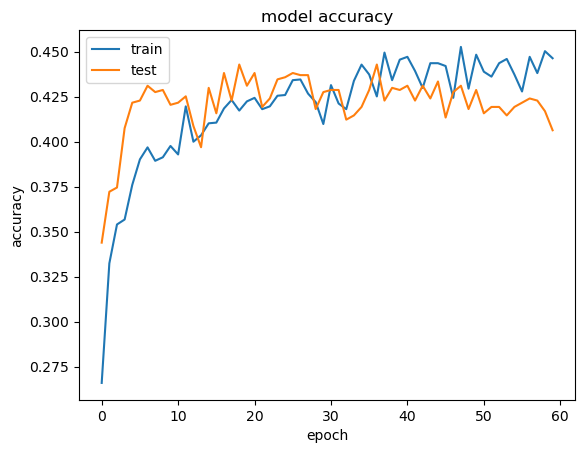

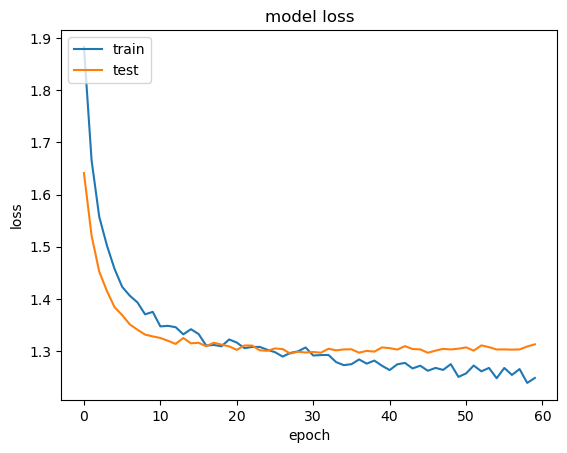

In [39]:
history = model.history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
preds = np.argmax(model.predict(X_test), axis=-1)
test = np.argmax(y_test, axis=-1)
print(confusion_matrix(preds,test))
print(classification_report(preds, test))
print("Balanced Accuracy Score --> ", balanced_accuracy_score(preds,test))
print("Accuracy Score --> ", accuracy_score(preds,test))

27/27 [==============================] - 0s 998us/step
[[  3   3   1   0   0   0   0   0]
 [  8   9   5   2   0   0   0   0]
 [ 17  60  57  49   9   0   0   0]
 [  7  16  60  89  61  14   0   0]
 [  0   2  16  59 108  67   0   1]
 [  0   0   0   2  33  72   6   6]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   7]]
              precision    recall  f1-score   support

           0       0.09      0.43      0.14         7
           1       0.10      0.38      0.16        24
           2       0.41      0.30      0.34       192
           3       0.44      0.36      0.40       247
           4       0.51      0.43      0.47       253
           5       0.47      0.61      0.53       119
           6       0.00      0.00      0.00         0
           7       0.50      1.00      0.67         7

    accuracy                           0.41       849
   macro avg       0.32      0.44      0.34       849
weighted avg       0.45      0.41      0.42       849

Balanced Accu

## Findings & Communication

- Treating the problem as a multiclass classification we see that,
    - The Deep Learning model with Regularization gives the best test accuracy at around 44.41% (43.8% after removing Professional) while the best test balanced accuracy score at 49.9% (50.9% after removing Professional) which is a big increase. The average F1 score for all classes came out to be 33.8% (39% after removing Professional).
    - The XGBoost model comes second and takes lesser time to train than the Deep Learning model and can be used to interpret which features are impactful in predicting the rank.
    - The LightGBM model is also a good alternative for fast and production-ready performance.  

<br>

- Guidance over collecting data
    - One alternative that I would like to suggest is to focus on **predicting MMR** rather than rank. MMR prediction can be then thought of as a **Regression** making it easier for the model to predict a value rather than predicting a rank.
    - I would suggest the data collectors to keep the GrandMaster and all the other ranks data **separate** from Professional leagues, since 'Professional' is **not** a rank in-game and the professionals might be at a different level and this will introduce some discrepancy within the data unless we collect more. Instead try to get their data and include it in the rank style.
    - I also want to know if we're collecting the player's data as the season progresses, or are we just taking an average case? It would be awesome to capture **seasonal progress** of a player in the data to know what they might be doing or how they might be changing their gameplay.
    - Lot of times it gets difficult to categorize people in ranks that are closer, since there may be a case where a person in the lower end of a higher rank like Silver would be worse than a person in the higher end of a lower rank like Bronze. I would suggest to create **smaller buckets** like Gold-Bronze, Platinum-Master, and so on. This could help the model really differentiate between these brackets. Including MMR could help solve this issue as well.